<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Tensorflow_custom_models_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The 95% of the use cases we will encounter will not require anything else than TensorFlow’s high-level API, `tf.keras`. In previous notebooks we have built various neural network architectures, including regression and classification nets, deep nets, and self-normalizing nets, using all sorts of techniques, such as Batch Normalization, dropout, learning rate schedules, and more. But now it’s time to dive deeper into TensorFlow and take a look at its lower-level Python API. In a previous notebook, we took a quick tour of TensorFlow and we saw the basic operations around tensors and other data structures (see [notebook](https://github.com/victorviro/Deep_learning_python/blob/master/TensorFlow_operations_and_data_structures.ipynb)). This will be useful when we need extra control, to write custom loss functions, custom metrics, layers, models, initializers, regularizers, weight constraints and more. We may even need to fully control the training loop itself, for example, to apply special transformations or constraints to the gradients (beyond just clipping them), or to use multiple optimizers for different parts of the network. We will cover all these cases in this notebook, then in the next notebook, we will also look at how we can boost our custom models and training algorithms using TensorFlow’s automatic graph generation feature. 

## Customizing models and training algorithms

### Custom loss functions

Suppose we want to train a regression model, but our training set is a bit noisy. Of course, we start by trying to clean up our dataset by removing or fixing the outliers, but it turns out to be insufficient, the dataset is still noisy. Which loss function should we use? The mean squared error might penalize large errors too much, so our model will end up being imprecise. The mean absolute error would not penalize outliers as much, but training might take a while to converge and the trained model might not be very precise. This is probably a good time to use the Huber loss (introduced in [here](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_linear_regression_and_regularized_linear_models.ipynb)). The Huber loss is not currently part of the official Keras API, but it is available in tf.keras (we can just use an instance of the `keras.losses.Huber` class). But let’s pretend it’s not there. Let's create a function that takes the labels and predictions as arguments, and use TensorFlow operations to compute every instance’s loss:

In [1]:
from tensorflow import keras
import tensorflow as tf

In [2]:
# Let's start by loading and preparing the California housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

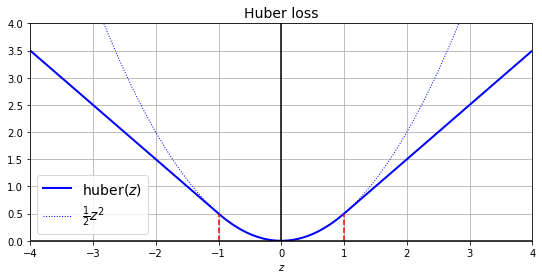

In [4]:
#@title
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(9, 4))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

**Note**: For better performance, we should use a vectorized implementation, as in this example. Moreover, if we want to benefit from TensorFlow’s graph features, we should use only TensorFlow operations.

It is also preferable to return a tensor containing one loss per instance, rather than returning the mean loss. This way, Keras can apply class weights or sample weights when requested.


Next, we can just use this loss when we compile the Keras model, then train our model:

In [5]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5429 - mae: 0.8978 - val_loss: 0.2136 - val_mae: 0.5082
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2104 - mae: 0.5058 - val_loss: 0.1942 - val_mae: 0.4824


For each batch during training, Keras will call the `huber_fn()` function
to compute the loss, and use it to perform a Gradient Descent step. Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.

### Saving and Loading Models That Contain Custom Components

Saving a model containing a custom loss function actually works fine, as Keras just saves the name of the function. However, whenever we load it, we need to provide a dictionary that maps the function name to the actual function. More generally, when we load a model containing custom objects, we need to map the names to the objects:

In [6]:
model.save("my_model_with_a_custom_loss.h5")

In [7]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [8]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2015 - mean_absolute_error: 0.4947 - val_loss: 0.1867 - val_mean_absolute_error: 0.4713
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1972 - mean_absolute_error: 0.4880 - val_loss: 0.2022 - val_mean_absolute_error: 0.4878


With the current implementation, any error between -1 and 1 is considered “small”. But what if we want a different threshold? One solution is to create a function that creates a configured loss function:

In [9]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


In [10]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [11]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2179 - mae: 0.4878 - val_loss: 0.2302 - val_mae: 0.4763
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2149 - mae: 0.4836 - val_loss: 0.2152 - val_mae: 0.4689


Unfortunately, when we save the model, the threshold will not be saved. This means that we will have to specify the threshold value when loading the model (note that the name to use is "`huber_fn`", which is the name of the function we gave Keras, not the name of the function that created it):

In [12]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [13]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [14]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2108 - mean_absolute_error: 0.4790 - val_loss: 0.1951 - val_mean_absolute_error: 0.4565
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2073 - mean_absolute_error: 0.4739 - val_loss: 0.2024 - val_mean_absolute_error: 0.4563


We can solve this by creating a subclass of the `keras.losses.Loss` class, and implement its `get_config()` method:

In [15]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        self.name = "HuberLoss"
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        tf.name_scope("name")
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- The constructor accepts `**kwargs` and passes them to the parent constructor, which handles standard hyperparameters: the name of the loss and the reduction algorithm to use to aggregate the individual instance losses. By default, it is "`sum_over_batch_size`", which means that the loss will be the sum of the instance losses, possibly weighted by the sample weights, if any, and then divide the result by the batch size (not by the sum of weights, so this is not the weighted mean). Other possible values are `"sum"` and `None`.

- The `call()` method takes the labels and predictions, computes all the instance losses, and returns them.

- The `get_config()` method returns a dictionary mapping each hyperparameter name to its value. It first calls the parent class’s `get_config()` method, then adds the new hyperparameters to this dictionary (note that the convenient {`**x`} syntax was added in Python 3.5).

We can then use any instance of this class when we compile the model:


In [16]:

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [17]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [18]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.8064 - mae: 0.9606 - val_loss: 0.3456 - val_mae: 0.5691
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2475 - mae: 0.5175 - val_loss: 0.2299 - val_mae: 0.4930


When we save the model, the threshold will be saved along with it, and when we load the model we just need to map the class name to the class itself:

In [19]:
model.save("my_model_with_a_custom_loss_class.h5")

In [20]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})
print(model.loss.threshold)

2.0


In [21]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2309 - mean_absolute_error: 0.5017 - val_loss: 0.2424 - val_mean_absolute_error: 0.5028
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2259 - mean_absolute_error: 0.4964 - val_loss: 0.2107 - val_mean_absolute_error: 0.4785


When we save a model, Keras calls the loss instance’s `get_config()` method and saves the config as JSON in the HDF5 file. When we load the model, it calls the `from_config()` class method on the `HuberLoss` class: this method is implemented by the base class (`Loss`) and just creates an instance of the class, passing `**config` to the constructor.

**Note**: The Keras API only specifies how to use subclassing to define layers, models, callbacks, and regularizers. If we build other components (such as losses, metrics, initializers or constraints) using subclassing, they may not be portable to other Keras implementations.

### Custom Activation Functions, Initializers, Regularizers, and Constraints

Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers and even full models can be customized in very much the same way. Most of the time, we will just need to write a simple function, with the appropriate inputs and outputs. For example, here are examples of a custom activation function (equivalent to `keras.activations.softplus`), a custom Glorot initializer (equivalent to `keras.initializers.glorot_normal`), a custom $l_1$ regularizer (equivalent to `keras.regularizers.l1(0.01)`) and a custom constraint that ensures weights are all positive (equivalent to `keras.constraints.nonneg()`):

In [22]:
keras.backend.clear_session()

In [23]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

As we can see, the arguments depend on the type of custom function. These custom functions can then be used normally, for example:

In [24]:
layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

The activation function will be applied to the output of this `Dense` layer, and its result will be passed on to the next layer. The layer’s weights will be initialized using the value returned by the initializer. At each training step, the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. Finally, the constraint function will be called after each training step, and the layer’s weights will be replaced by the constrained weights.

In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])


model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.7394 - mae: 0.8748 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.7544 - mae: 0.5274 - val_loss: inf - val_mae: inf


In [26]:
model.save("my_model_with_many_custom_parts.h5")

In [27]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

If a function has some hyperparameters that need to be saved along with the model, then we will want to subclass the appropriate class, such as `keras.regularizers.Regularizer`, `keras.constraints.Constraint`, `keras.initializers.Initializer` or `keras.layers.Layer` (for any layer, including activation functions). For example, much like we did for the custom loss, here is a simple class for $l_1$ regularization, that saves its `factor` hyperparameter (this time we do not need to call the parent constructor or the `get_config()` method, as they are not defined by the parent class):

In [28]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

Note that we must implement the `call()` method for losses, layers (including activation functions) and models, or the `__call__()` method for regularizers, initializers and constraints. For metrics, things are a bit different, as we will see now.

In [29]:
import keras
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.6036 - mae: 0.8791 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6325 - mae: 0.5165 - val_loss: inf - val_mae: inf


In [30]:
model.save("my_model_with_many_custom_parts.h5")

In [31]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

### Custom Metrics

Losses and metrics are conceptually not the same things: losses are used by Gradient Descent to train a model, so they must be differentiable (at least where they are evaluated) and their gradients should not be 0 everywhere. Plus, it’s okay if they are not easily interpretable by humans (e.g. cross-entropy). 

In contrast, metrics are used to evaluate a model, they must be more easily interpretable, and they can be non-differentiable or have 0 gradients everywhere (e.g., accuracy).

That said, in most cases, defining a custom metric function is exactly the same as defining a custom loss function. In fact, we could even use the Huber loss function we created earlier as a metric (the Huber loss is seldom used as a metric, the MAE or MSE are preferred), it would work just fine (and persistence would also work the same way, in this case only saving the name of the function, "`huber_fn`" ):

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

history = model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.8707 - huber_fn: 0.8707
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2595 - huber_fn: 0.2595


Using the MSE like loss function:

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [34]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [35]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 2.0962 - huber_fn: 0.9386
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.4944 - huber_fn: 0.2413


For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what we want. But not always! 

Consider a binary classifier’s precision, for example. The precision is the number of true positives divided by the number of positive predictions (including both true positives and false positives). Suppose the model made 5 positive predictions in the first batch, 4 of which were correct: that’s 80% precision. Then suppose the model made 3 positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If we just compute the mean of these two precisions, we get 40%. But wait a second, this is not the model’s precision over these two batches! Indeed, there were a total of 4 true positives (4 + 0) out of 8 positive predictions (5 + 3), so the overall precision is 50%, not 40%.

What we need is an object that can keep track of the number of true positives and the number of false positives, and compute their ratio when requested. This is precisely what the `keras.metrics.Precision` class does:

In [36]:
import keras
import tensorflow as tf

In [37]:
precision = tf.keras.metrics.Precision()
print(precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]))
print(precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]))


tf.Tensor(0.8, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


In this example, we created a `Precision` object, then we used it like a function, passing it the labels and predictions for the first batch, then for the second batch (note that we could also have passed sample weights). We used the same number of true and false positives as in the example we just discussed. After the first batch, it returns the precision of 80%, then after the second batch it returns 50% (which is the overall precision so far, not the second batch’s precision). This is called a streaming metric (or stateful metric), as it is gradually updated, batch after batch.

At any point, we can call the `result()` method to get the current value of the metric. We can also look at its variables (tracking the number of true and false positives) using the `variables` attribute, and reset these variables using the `reset_states()` method:

In [38]:
print(precision.result().numpy())
print(precision.variables)
precision.reset_states() # both variables get reset to 0.0

0.5
[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>, <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]


If we need to create such a streaming metric, we can just create a subclass of the `keras.metrics.Metric` class. Here is a simple example that keeps track of the total Huber loss and the number of instances seen so far. When asked for the result, it returns the ratio, which is simply the mean Huber loss:

In [49]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- The constructor uses the `add_weight()` method to create the variables needed to keep track of the metric’s state over multiple batches, in this case, the sum of all Huber losses (`total`) and the number of instances seen so far (`count`). We could just create variables manually if we preferred. Keras tracks any `tf.Variable` that is set as an attribute (and more generally, any "trackable" object, such as layers or models).

- The `update_state()` method is called when we use an instance of this class as a function (as we did with the `Precision` object). It updates the variables given the labels and predictions for one batch (and sample weights, but in this case we just ignore them).

- The `result()` method computes and returns the final result, in this case just the mean Huber metric over all instances. When we use the metric as a function, the `update_state()` method gets called first, then the `result()` method is called, and its output is returned.

- We also implement the `get_config()` method to ensure the `threshold` gets saved along with the model.

- The default implementation of the `reset_states()` method just resets all variables to 0.0 (but we can override it if needed).

When we define a metric using a simple function, Keras automatically calls it for each batch, and it keeps track of the mean during each epoch, just like we did manually. So the only benefit of our `HuberMetric` class is that the `threshold` will be saved. But of course, some metrics, like precision, cannot simply be averaged over batches: in those cases, there’s no other option than to implement a streaming metric.

In [46]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


In [50]:
m = HuberMetric(2.)

m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [51]:
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [52]:
m.reset_states()

In [53]:
import numpy as np

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [54]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2)

In [58]:
model.save("my_model_with_a_custom_metric.h5")

In [59]:
model = keras.models.load_model("/content/my_model_with_a_custom_metric.h5",           # TODO: check PR #25956
                               custom_objects={"huber_fn": create_huber(2.0),
                                               "HuberMetric": HuberMetric})

In [60]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2278 - huber_metric: 0.2278


In TF 2.2, tf.keras adds an extra first metric in model.metrics at position 0 (see [TF issue](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the HuberMetric.

In [61]:
model.metrics[-1].threshold

2.0

### Custom Layers

We may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. In this case, we will need to create a custom layer. Or sometimes we may simply want to build a very repetitive architecture, containing identical blocks of layers repeated many times, and it would be convenient to treat each block of layers as a single layer. For example, if the model is a sequence of layers A, B, C, A, B, C, A, B, C, then we might want to define a custom layer D containing layers A, B, C, and our model would then simply be D, D, D. Let’s see how to build custom layers.

First, some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If we want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a `keras.layers.Lambda layer`. For example, the following layer will apply the exponential function to its inputs:

In [56]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

This custom layer can then be used like any other layer, using the sequential API, the functional API, or the subclassing API. We can also use it as an activation function (or we could just use `activation=tf.exp`, or `activation=keras.activations.exponential`, or simply `activation="exponential"` ). The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales (e.g., $0.001$, $10.$, $1000.$).

To build a custom stateful layer (i.e., a layer with weights), we need to create a subclass of the `keras.layers.Layer` class. For example, the following class implements a simplified version of the Dense layer:



In [62]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

- The constructor takes all the hyperparameters as arguments (in this example just `units` and `activation`), and importantly it also takes a `**kwargs` argument. It
calls the parent constructor, passing it the `kwargs`: this takes care of standard arguments such as `input_shape`, `trainable`, `name`, and so on. Then it saves the hyperparameters as attributes, converting the `activation` argument to the appropriate activation function using the `keras.activations.get()` function (it
accepts functions, standard strings like `"relu"` or `"selu"` , or simply `None`) (this function is specific to `tf.keras`, we could use `keras.activations.Activation` instead).

- The `build()` method’s role is to create the layer’s variables, by calling the `add_weight()` method for each weight. The `build()` method is called the first
time the layer is used. At that point, Keras will know the shape of this layer’s inputs, and it will pass it to the `build()` method (The Keras API calls this argument input_shape, but since it also includes the batch dimension, we prefer to call it batch_input_shape, same for `compute_output_shape()`), which is often necessary to create some of the weights. For example, we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the `"kernel"`): this corresponds to the size of the last dimension of the inputs. At the end of the `build()` method (and only at the end), we must call the parent’s `build()` method: this tells Keras that the layer is built (it just sets `self.built = True`).

- The `call()` method actually performs the desired operations. In this case, we compute the matrix multiplication of the inputs `X` and the layer’s kernel, we add the bias vector, we apply the activation function to the result, and this gives us the output of the layer.

- The `compute_output_shape()` method simply returns the shape of this layer’s outputs. In this case, it is the same shape as the inputs, except the last dimension
is replaced with the number of neurons in the layer. Note that in tf.keras, shapes are instances of the `tf.TensorShape` class, which we can convert to Python lists
using `as_list()`.

- The `get_config()` method is just like earlier. Note that we save the activation function’s full configuration by calling `keras.activations.serialize()` . 

You can now use a `MyDense` layer just like any other layer!

In [63]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 825us/step - loss: 0.5474


0.5473727583885193

**Note**: You can generally omit the `compute_output_shape()` method, as tf.keras automatically infers the output shape, except when the
layer is dynamic (as we will see shortly). In other Keras implementations, this method is either required or by default it assumes the output shape is the same as the input shape.

To create a layer with multiple inputs (e.g., `Concatenate`), the argument to the `call()` method should be a tuple containing all the inputs, and similarly, the argument to the `compute_output_shape()` method should be a tuple containing each input’s batch
shape. To create a layer with multiple outputs, the `call()` method should return the list of outputs, and the `compute_output_shape()` should return the list of batch output shapes (one per output). For example, the following toy layer takes two inputs and returns two outputs:

In [69]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

This layer may now be used like any other layer, but of course only using the functional and subclassing APIs, not the sequential API (which only accepts layers with
one input and one output).





In [70]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

If our layer needs to have a different behavior during training and during testing (e.g., if it uses `Dropout` or `BatchNormalization` layers), then we must add a `training` argument to the `call()` method and use this argument to decide what to do. For example, let’s create a layer that adds Gaussian noise during training (for regularization), but does nothing during testing (Keras actually has a layer that does the same thing: `keras.layers.GaussianNoise`):

In [71]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [72]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.4904 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 781us/step - loss: 0.3990


0.39900389313697815

With that, we can now build any custom layer we need! Now let’s create custom models.

### Custom Models

We already looked at custom model classes when we discussed the subclassing API (see [notebook](https://github.com/victorviro/Deep_learning_python/blob/master/Keras_Functional_API.ipynb)). It is actually quite straightforward, just subclass the `keras.models.Model` class, create layers and variables in the constructor, and implement the `call()` method to do whatever you want the model to do. For example, suppose you want to build the model represented in the next figure:

![](https://i.ibb.co/NTvMVbt/custom-model.png)

The inputs go through a first dense layer, then through a residual block composed of two dense layers and an addition operation (a residual block adds its inputs to its outputs), then through this same residual block 3 more times, then through a second residual block, and the final result goes through a dense output layer. Note that this model does not make much sense, it’s just an example to illustrate the fact that we can easily build any kind of model we want, even containing loops and skip connections. To implement this model, it is best to first create a `ResidualBlock` layer, since we are going to create a couple of identical blocks (and we might want to reuse it in another model):

In [73]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

This layer is a bit special since it contains other layers. This is handled transparently by Keras: it automatically detects that the hidden attribute contains trackable objects (layers in this case), so their variables are automatically added to this layer’s list of variables. The rest of this class is self-explanatory. Next, let’s use the subclassing API to define the model itself:

In [74]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

We create the layers in the constructor and use them in the `call()` method. This model can then be used like any other model (compile it, fit it, evaluate it, and use it to make predictions). If we also want to be able to save the model using the `save()` method, and load it using the `keras.models.load_model()` function, you must implement the `get_config()` method (as we did earlier) in both the `ResidualBlock` class and the `ResidualRegressor` class. Alternatively, we can just save and load the weights using the `save_weights()` and `load_weights()` methods.


The `Model` class is actually a subclass of the `Layer` class, so models can be defined and used exactly like layers. But a model also has some extra functionalities, including of course its `compile()`, `fit()`, `evaluate()` and `predict()` methods (and a few variants, such as `train_on_batch()` or `fit_generator()`), plus the `get_layers()` method (which can return any of the model’s layers by name or by index), and the `save()` method (and support for `keras.models.load_model()` and `keras.models.clone_model()`). So if models provide more functionalities than layers, why not just define every layer as a model? Well, technically we could, but it is probably cleaner to distinguish the internal components of our model (layers or reusable blocks of layers) from the model itself. The former should subclass the `Layer` class, while the latter should subclass the `Model` class.

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

X_new_scaled = X_test_scaled

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 9.1324
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0578
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8866
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5842
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.6481


In [76]:
model.save("my_custom_model.ckpt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [77]:
model = keras.models.load_model("my_custom_model.ckpt")

In [78]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.9154
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4779
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4867
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5609
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5365


We could have defined the model using the sequential API instead:

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])


In [80]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.3809
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.4852


With that, we can quite naturally and concisely build almost any model that we find in a paper, either using the sequential API, the functional API, the subclassing API, or even a mix of these. 

### Computing Gradients Using Autodiff

To understand how to use autodiff (see notebook [TensorFlow’s autodifferentiation](https://github.com/victorviro/Deep_learning_python/blob/master/TensorFlow%E2%80%99s_autodifferentiation.ipynb)) to compute gradients automatically, let’s consider a simple toy function:

$$f(w_1,w_2) = 3w_1^2+2w_1w_2$$

In [81]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

We can analytically find that the partial derivative of this function with regards to $w_1$,  $\frac{∂f}{∂w_1}=6w_1+2w_2$ . We can also find that its partial derivative with regards to $w_2$ is $\frac{∂f}{∂w_2}=2w_1$ . For example, at the point $(w1, w2) = (5, 3)$ , these partial derivatives are equal to 36 and 10, respectively, so the gradient vector at this point is $\nabla f(5,3)=(36, 10)$.

But if this were a neural network, the function would be much more complex, typically with tens of thousands of parameters, and finding the partial derivatives analytically by hand would be an almost impossible task. One solution could be to compute an approximation of each partial derivative by measuring how much the function’s output changes when you tweak the corresponding parameter:

$$\nabla f(5,3)≈(\frac{f(w_1+\epsilon,+w_2)}{\epsilon}, \frac{f(w_1,w_2+\epsilon)}{\epsilon})$$

In [82]:
w1, w2 = 5, 3
eps = 1e-6
gradients = (f(w1 + eps, w2) - f(w1, w2)) / eps, (f(w1, w2 + eps) - f(w1, w2)) / eps
print(gradients)

(36.000003007075065, 10.000000003174137)


This works rather well and it is trivial to implement, but it is just an approximation, and importantly we need to call `f()` at least once per parameter (not twice, since we could compute `f(w1, w2)` just once). This makes this approach intractable for large neural networks. So instead we should use autodiff (see notebook [TensorFlow’s autodifferentiation](https://github.com/victorviro/Deep_learning_python/blob/master/TensorFlow%E2%80%99s_autodifferentiation.ipynb)). TensorFlow makes this pretty simple:

In [83]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    gradients = tape.gradient(z, [w1, w2])

We first define two variables `w1` and `w2`, then we create a `tf.GradientTape` context that will automatically record every operation that involves a variable, and finally, we ask this tape to compute the gradients of the result z with regards to both variables `[w1, w2]`. Let’s take a look at the gradients that TensorFlow computed:

In [84]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

Not only is the result accurate (the precision is only limited by the floating-point errors), but the `gradient()` method only goes through the recorded computations once (in reverse order), no matter how many variables there are, so it is incredibly efficient.

**Note**: We just put the strict minimum inside the `tf.GradientTape()` block, to save memory. Alternatively, we can pause recording by creating a `with tape.stop_recording()` block inside the `tf.GradientTape()` block.

The tape is automatically erased immediately after we call its `gradient()` method, so we will get an exception if we try to call gradient() twice:

In [86]:
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, w1) # => tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2) # RuntimeError!
except Exception as err:
    print(err)

GradientTape.gradient can only be called once on non-persistent tapes.


If we need to call `gradient()` more than once, we must make the tape persistent, and delete it when you are done with it to free resources:

In [87]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, w1) # => tensor 36.0
dz_dw2 = tape.gradient(z, w2) # => tensor 10.0, works fine now!
del tape

By default, the tape will only track operations involving variables, so if we try to compute the gradient of `z` with regards to anything else than a variable, the result will be `None`:

In [88]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

However, we can force the tape to watch any tensors we like, to record every operation that involves them. We can then compute gradients with regards to these tensors, as if they were variables:

In [89]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients


[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

This can be useful in some cases, for example, if you want to implement a regularization loss that penalizes activations that vary a lot when the inputs vary little: the loss will be based on the gradient of the activations with regards to the inputs. Since the
inputs are not variables, you would need to tell the tape to watch them.

If you compute the gradient of a list of tensors (e.g., `[z1, z2, z3]` ) with regards to some variables (e.g., `[w1, w2]` ), TensorFlow actually efficiently computes the sum of the gradients of these tensors (i.e., gradient `(z1, [w1, w2])`, plus gradient `(z2, [w1, w2])`, plus gradient `(z3, [w1, w2])`). 

In [90]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

Due to the way reverse-mode autodiff works, it is not possible to compute the individual gradients (`z1`, `z2` and `z3`) without actually calling `gradient()` multiple times (once for `z1`, once for `z2` and once for `z3`),
which requires making the tape persistent (and deleting it afterward).

In [91]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In some rare cases, we may want to stop gradients from backpropagating through some part of our neural network. To do this, we must use the `tf.stop_gradient()`
function: it just returns its inputs during the forward pass (like `tf.identity()`), but it does not let gradients through during backpropagation (it acts like a constant). For example:

In [92]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

Finally, you may occasionally run into some numerical issues when computing gradients. For example, if you compute the gradients of the `my_softplus()` function for
large inputs, the result will be NaN:

In [93]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

This is because computing the gradients of this function using autodiff leads to some numerical difficulties: due to floating-point precision errors, autodiff ends up computing infinity divided by infinity (which returns NaN). Fortunately, we can analytically find that the derivative of the softplus function is just $\frac{1}{1+\frac{1}{e^x}}$, which is numerically stable. Next, we can tell TensorFlow to use this stable function when
computing the gradients of the `my_softplus()` function, by decorating it with `@tf.custom_gradient` , and making it return both its normal output and the function
that computes the derivatives (note that it will receive as input the gradients that were backpropagated so far, down to the softplus function, and according to the chain rule we should multiply them with this function’s gradients):

In [94]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

Now when we compute the gradients of the `my_better_softplus()` function, we get the proper result, even for large input values (however, the main output still explodes because of the exponential: one workaround is to use `tf.where()` to just return the
inputs when they are large).

In [96]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [97]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

### Custom Training Loops

In some rare cases, the `fit()` method may not be flexible enough for what we need to do. For example, if we want to use two different optimizers. Since the `fit()` method only uses one optimizer (the one that we specify when compiling the model), implementing this requires writing our own custom loop.

We may also like to write our own custom training loops simply to feel more confident that it does precisely what we intended it to do (perhaps we are unsure about
some details of the `fit()` method). It can sometimes feel safer to make everything explicit. However, remember that writing a custom training loop will make our code longer, more error-prone, and harder to maintain.

**Note**: Unless we really need the extra flexibility, we should prefer using the `fit()` method rather than implementing our own training loop, especially if we work in a team.

First, let’s build a simple model. No need to compile it, since we will handle the training loop manually:

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next, let’s create a tiny function that will randomly sample a batch of instances from the training set (the Data API offers a much better alternative):

In [99]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let’s also define a function that will display the training status, including the number of steps, the total number of steps, the mean loss since the start of the epoch (i.e., we will use the `Mean` metric to compute it), and other metrics:

In [100]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

This code is self-explanatory, unless you are unfamiliar with Python string formatting: `{:.4f}` will format a float with 4 digits after the decimal point. Moreover, using `\r` (carriage return) along with `end=""` ensures that the status bar always gets printed on the same line. 

First, we need to define some hyperparameters, choose the optimizer, the loss function, and the metrics (just the MAE in this example):

In [101]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

And now we are ready to build the custom loop!

In [102]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 - mean: 0.6440 - mean_absolute_error: 0.5222


- We create two nested loops: one for the epochs, the other for the batches within an epoch.

- Then we sample a random batch from the training set.

- Inside the `tf.GradientTape()` block, we make a prediction for one batch (using the model as a function), and we compute the loss: it is equal to the main loss
plus the other losses (in this model, there is one regularization loss per layer). Since the `mean_squared_error()` function returns one loss per instance, we compute the mean over the batch using `tf.reduce_mean()` (if we wanted to apply different weights to each instance, this is where we would do it). The regularization losses are already reduced to a single scalar each, so we just need to sum them (using `tf.add_n()`, which sums multiple tensors of the same shape
and data type).

- Next, we ask the tape to compute the gradient of the loss with regards to each trainable variable (not *all* variables!), and we apply them to the optimizer to perform a Gradient Descent step.

- Next, we update the mean loss and the metrics (over the current epoch), and we display the status bar.

- At the end of each epoch, we display the status bar again to make it look complete and to print a line feed, and we reset the states of the mean loss and the
metrics.

**Note**: We did not process every single instance in the training set because we sampled instances randomly, so some were processed more than once while others were not processed at all. In practice that’s fine. Moreover, if the training set size is not a multiple of the batch size, we will miss a few instances.

If we set the optimizer’s `clipnorm` or `clipvalue` hyperparameters, it will take care of this for us. If we want to apply any other transformation to the gradients, simply do so before calling the `apply_gradients()` method.

If we add weight constraints to your model (e.g., by setting `kernel_constraint` or `bias_constraint` when creating a layer), we should update the training loop to
apply these constraints just after `apply_gradients()`:

In [104]:
for variable in model.variables:
    if variable.constraint is not None:
        variable.assign(variable.constraint(variable))

Most importantly, this training loop does not handle layers that behave differently during training and testing (e.g., `BatchNormalization` or `Dropout`). To handle these, we need to call the model with `training=True` and make sure it propagates this to
every layer that needs it.

As we can see, there are quite a lot of things we need to get right, it is easy to make a mistake. But on the bright side, we get full control, so it’s your call.

We could use the handy tqdm library to see a progress bar in the training loop.

In [103]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

In the next notebook, we will see how we can use TensorFlow’s automatic graph generation feature: it can speed up our custom code considerably, and it will also make it portable to any platform supported by TensorFlow.